Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


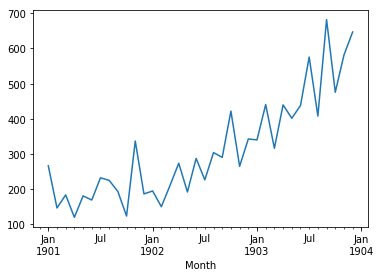

In [2]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
 
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()



We can see that the Shampoo Sales dataset has a clear trend.

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas. The example below plots the autocorrelation for a large number of lags in the time series.


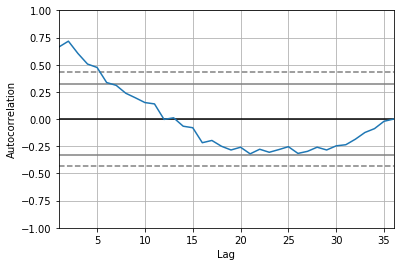

In [3]:
from pandas.plotting import autocorrelation_plot
 
autocorrelation_plot(series)
pyplot.show()


ARIMA

The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

1)Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2)The model is prepared on the training data by calling the fit() function.
3)Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted. Let’s start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.


D:\Users\dell\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Users\dell\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Sat, 20 Jul 2019   AIC                            406.340
Time:                        19:09:04   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

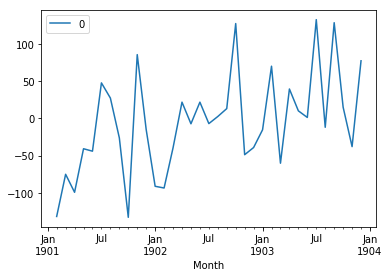

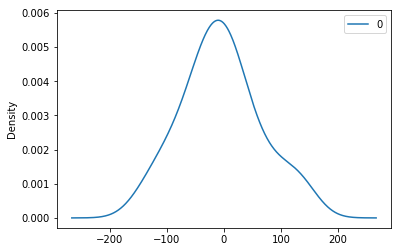

                0
count   35.000000
mean    -5.495295
std     68.132877
min   -133.296686
25%    -42.477964
50%     -7.186673
75%     24.748258
max    133.237889


In [4]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())


Rolling Forecast ARIMA Model

The ARIMA model can be used to forecast future time steps.

We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’.

Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

Putting this all together.


predicted=349.117669, expected=342.300000
predicted=306.513025, expected=339.700000
predicted=387.376423, expected=440.400000
predicted=348.154259, expected=315.900000
predicted=386.308819, expected=439.300000
predicted=356.082056, expected=401.300000
predicted=446.379526, expected=437.400000
predicted=394.737264, expected=575.500000
predicted=434.915601, expected=407.600000
predicted=507.923413, expected=682.000000
predicted=435.482930, expected=475.300000
predicted=652.743793, expected=581.300000
predicted=546.343499, expected=646.900000
Test MSE: 6958.326


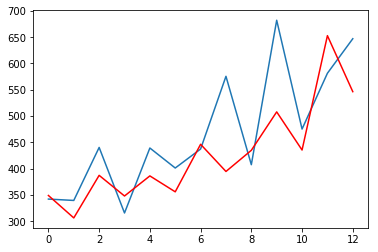

In [5]:
from sklearn.metrics import mean_squared_error
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


Configuring an ARIMA Model

In summary, the steps of this process are as follows:

Model Identification. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required. Parameter Estimation. Use a fitting procedure to find the coefficients of the regression model. Model Checking. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model. The process is repeated until either a desirable level of fit is achieved on the in-sample or out-of-sample observations (e.g. training or test datasets).
